## LAB 4 - classifiers

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from models import MLClassifier, ParzenClassifer, KNNClassifier
from utils import confusion_matrix, error_score, normalize_data
from visualization import plot_2D, plot_3D

plt.rcParams['figure.figsize'] = [16, 7]

## 2 classes - 2 dimensions 

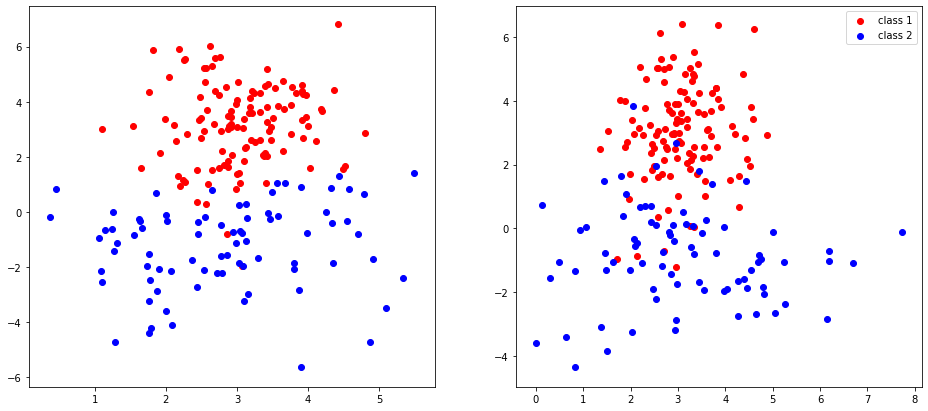

In [3]:
X, Y = np.load('data/lab4.p', allow_pickle=True)
plot_2D(X, Y)

We first convert the data in a canonical data structutre better suited for classification. This allow us to implement [classification models](models.py) which follows the style of scikit-learn's intuitive API, and can be applied to any number of classes and dimensions. For each classification task, we can `fit` the model to the training data, and `predict` the class of unseen samples, even though `fit` and `predict` do different things for each model.

In [4]:
x_train, x_test, y_train, y_test = normalize_data(X, Y)

This implementation design also allow us to check our results directly against sklearn's models, using the following method.

In [5]:
def train_test_evaluate(models):
    global x_train, x_test, y_train, y_test
    
    results = {
        'P( error )':{},
    }
    
    for desc, m in models.items():
        model = m['class'](**m['kwargs'])
        model.fit(x_train, y_train)
        y_pred_train = model.predict(x_train)
        y_pred_test = model.predict(x_test)
        err_train = error_score(y_pred_train, y_train)
        err_test = error_score(y_pred_test, y_test)
        cm_train = confusion_matrix(y_pred_train, y_train)
        cm_test = confusion_matrix(y_pred_test, y_test)

        variant = ['Reclassification', 'Testing']
        error = [err_train, err_test]
        confusion = [cm_train, cm_test]

        for var, err, cm in zip(variant, error, confusion):
            row_name = f'{desc} {var}'
            results['P( error )'][row_name]= f'{err:.2f}'
            for i, p_correct in enumerate(cm.diagonal()):
                true_positives = f'P( correct | w_{i+1} )'
                if true_positives not in results:
                    results[true_positives] = {}
                results[true_positives][row_name]= f'{p_correct:.2f}'
        
    return pd.DataFrame(results)

In [6]:
models = {
    "Maximum likelihood" : {'class':MLClassifier, 'kwargs' : {}},
    "Parzen h1 = 0.1" : {'class':ParzenClassifer, 'kwargs' : {'h':0.1}},
    "Parzen h1 = 5.0" : {'class':ParzenClassifer, 'kwargs' : {'h':5.0}},
    "Nearest neighbours k = 1" : {'class':KNNClassifier, 'kwargs' : {'k':1}},
    "Nearest neighbours k = 5" : {'class':KNNClassifier, 'kwargs' : {'k':5}}
}

train_test_evaluate(models)

,P( error ),P( correct | w_1 ),P( correct | w_2 )
Maximum likelihood Reclassification,0.05,0.97,0.94
Maximum likelihood Testing,0.10,0.93,0.85
Parzen h1 = 0.1 Reclassification,0.00,1.00,1.00
Parzen h1 = 0.1 Testing,0.24,0.93,0.50
Parzen h1 = 5.0 Reclassification,0.03,0.96,0.99
Parzen h1 = 5.0 Testing,0.10,0.92,0.86
Nearest neighbours k = 1 Reclassification,0.00,1.00,1.00
Nearest neighbours k = 1 Testing,0.11,0.93,0.84
Nearest neighbours k = 5 Reclassification,0.03,0.97,0.97
Nearest neighbours k = 5 Testing,0.10,0.93,0.86


We can check the consistency of our results against scikit-learn models. Sklearn does not implement a Parzen classifier directly, but it  implements a kernel density estimator using Parzen technique. We can convert this estimator into a classifier by comparing the kernel density estimations for all classes. The definition we use for the kernel density estimation is 

\begin{equation*}
p_N = \frac{k_N}{N V_N}
\end{equation*}

where

\begin{align*}
N &= \text{# of samples of dimension $l$} \\
h_N &= \frac{h_1} {\sqrt{N}} \\
V_N &= h_N^l \\
k_N &= \sum_{i=1}^N \varphi(\frac{x-x_i}{h_N}) \\
\end{align*}

and we use a gaussian kernel with $\Sigma = I$, i.e.

\begin{align*}
\varphi(u) = 2\pi^{-\frac{l}{2}} e^{-\frac{1}{2} u^T u}
\end{align*}

In [7]:
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from models import SKLParzenClassifier

sklearn_models = {
    "sklearn ML" : {'class':GaussianNB, 'kwargs' : {'var_smoothing':0}},
    "sklearn Parzen h1 = 0.1" : {'class':SKLParzenClassifier, 'kwargs' : {'h':0.1}},
    "sklearn Parzen h1 = 5.0" : {'class':SKLParzenClassifier, 'kwargs' : {'h':5.0}},
    "sklearn KNN k = 1" : {'class':KNeighborsClassifier, 'kwargs' : {'n_neighbors':1}},
    "sklearn KNN k = 5" : {'class':KNeighborsClassifier, 'kwargs' : {'n_neighbors':5}}
}


train_test_evaluate(sklearn_models)

,P( error ),P( correct | w_1 ),P( correct | w_2 )
sklearn ML Reclassification,0.05,0.97,0.93
sklearn ML Testing,0.09,0.93,0.88
sklearn Parzen h1 = 0.1 Reclassification,0.01,0.98,1.00
sklearn Parzen h1 = 0.1 Testing,0.11,0.92,0.84
sklearn Parzen h1 = 5.0 Reclassification,0.06,0.96,0.91
sklearn Parzen h1 = 5.0 Testing,0.09,0.93,0.89
sklearn KNN k = 1 Reclassification,0.00,1.00,1.00
sklearn KNN k = 1 Testing,0.11,0.93,0.84
sklearn KNN k = 5 Reclassification,0.03,0.97,0.97
sklearn KNN k = 5 Testing,0.10,0.93,0.86


## 3 classes - 2 dimensions 

In [8]:
X_2D3cl, _, _, _, _, Y_2D3cl, _, _, _, _ = np.load('data/lab4_2.p', allow_pickle=True)
x_train, x_test, y_train, y_test = normalize_data(X_2D3cl, Y_2D3cl)
train_test_evaluate(models)

,P( error ),P( correct | w_1 ),P( correct | w_2 ),P( correct | w_3 )
Maximum likelihood Reclassification,0.47,0.48,0.76,0.20
Maximum likelihood Testing,0.54,0.28,0.78,0.07
Parzen h1 = 0.1 Reclassification,0.05,0.92,0.94,1.00
Parzen h1 = 0.1 Testing,0.65,0.52,0.30,0.30
Parzen h1 = 5.0 Reclassification,0.40,0.88,0.52,0.50
Parzen h1 = 5.0 Testing,0.64,0.60,0.28,0.30
Nearest neighbours k = 1 Reclassification,0.05,1.00,0.90,1.00
Nearest neighbours k = 1 Testing,0.62,0.24,0.48,0.33
Nearest neighbours k = 5 Reclassification,0.27,0.76,0.78,0.63
Nearest neighbours k = 5 Testing,0.63,0.16,0.56,0.23


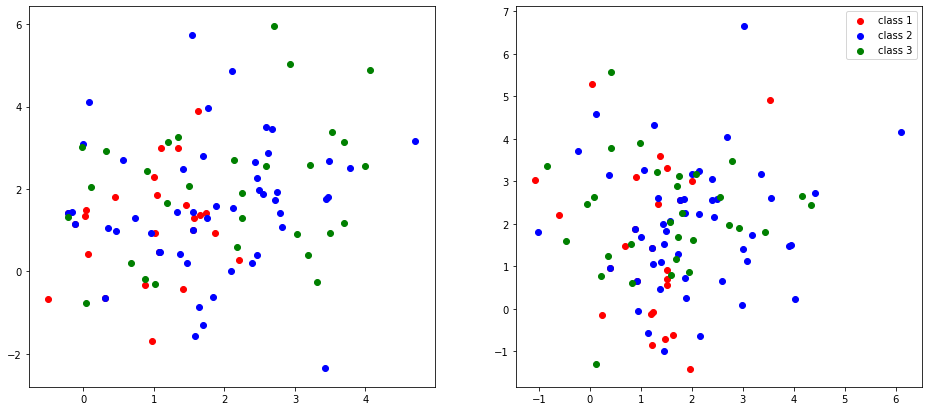

In [9]:
plot_2D(X_2D3cl, Y_2D3cl)

## 4 classes - 2 dimensions - low separability

In [10]:
_, X_2D4cl, _, _, _, _, Y_2D4cl, _, _, _ = np.load('data/lab4_2.p', allow_pickle=True)
x_train, x_test, y_train, y_test = normalize_data(X_2D4cl, Y_2D4cl)
train_test_evaluate(models)

,P( error ),P( correct | w_1 ),P( correct | w_2 ),P( correct | w_3 ),P( correct | w_4 )
Maximum likelihood Reclassification,0.57,0.40,0.56,0.44,0.32
Maximum likelihood Testing,0.55,0.52,0.52,0.52,0.24
Parzen h1 = 0.1 Reclassification,0.00,1.00,1.00,1.00,1.00
Parzen h1 = 0.1 Testing,0.74,0.20,0.36,0.20,0.28
Parzen h1 = 5.0 Reclassification,0.46,0.40,0.76,0.48,0.52
Parzen h1 = 5.0 Testing,0.67,0.24,0.44,0.24,0.40
Nearest neighbours k = 1 Reclassification,0.00,1.00,1.00,1.00,1.00
Nearest neighbours k = 1 Testing,0.74,0.16,0.36,0.24,0.28
Nearest neighbours k = 5 Reclassification,0.27,0.52,0.88,0.80,0.72
Nearest neighbours k = 5 Testing,0.68,0.32,0.40,0.32,0.24


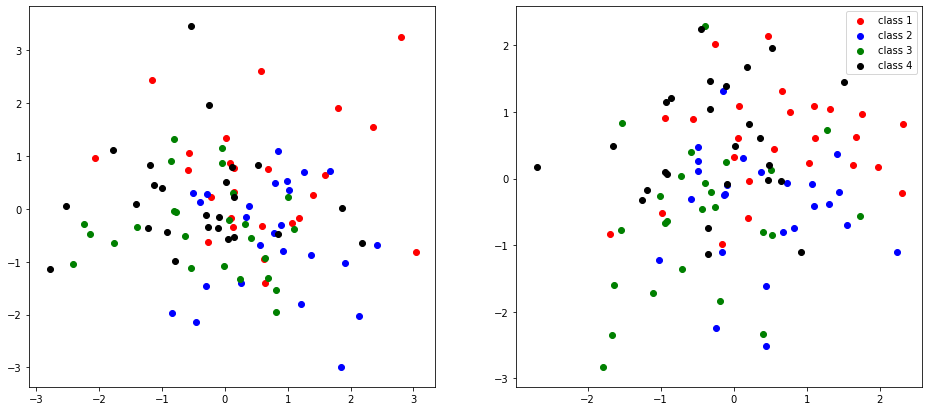

In [11]:
plot_2D(X_2D4cl, Y_2D4cl)

## 4 classes - 2 dimensions - medium separability

In [12]:
_, _, X_2D4cl_ms, _, _, _, _, Y_2D4cl_ms, _, _ = np.load('data/lab4_2.p', allow_pickle=True)
x_train, x_test, y_train, y_test = normalize_data(X_2D4cl_ms, Y_2D4cl_ms)
train_test_evaluate(models)

,P( error ),P( correct | w_1 ),P( correct | w_2 ),P( correct | w_3 ),P( correct | w_4 )
Maximum likelihood Reclassification,0.27,0.72,0.80,0.72,0.68
Maximum likelihood Testing,0.28,0.76,0.80,0.60,0.72
Parzen h1 = 0.1 Reclassification,0.00,1.00,1.00,1.00,1.00
Parzen h1 = 0.1 Testing,0.47,0.44,0.44,0.60,0.64
Parzen h1 = 5.0 Reclassification,0.24,0.64,0.84,0.76,0.80
Parzen h1 = 5.0 Testing,0.28,0.76,0.76,0.64,0.72
Nearest neighbours k = 1 Reclassification,0.00,1.00,1.00,1.00,1.00
Nearest neighbours k = 1 Testing,0.41,0.44,0.60,0.60,0.72
Nearest neighbours k = 5 Reclassification,0.16,0.72,0.80,0.96,0.88
Nearest neighbours k = 5 Testing,0.32,0.60,0.76,0.68,0.68


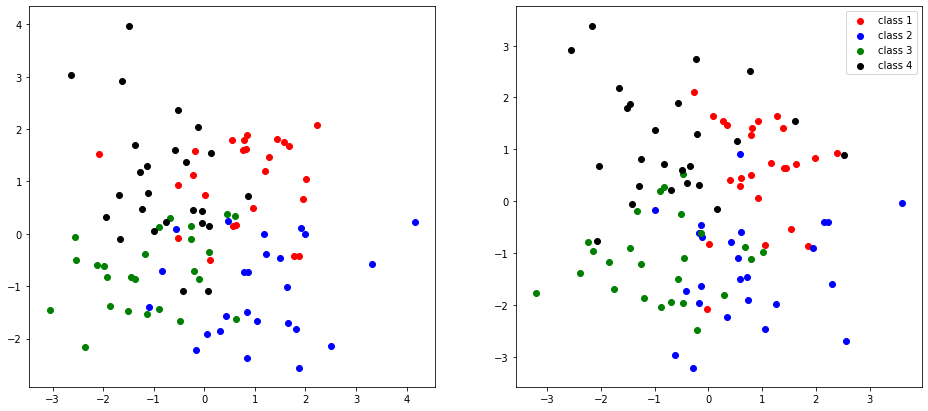

In [13]:
plot_2D(X_2D4cl_ms, Y_2D4cl_ms)

## 4 classes - 2 dimensions - high separability

In [14]:
_, _, _, X_2D4cl_hs, _, _, _, _, Y_2D4cl_hs, _ = np.load('data/lab4_2.p', allow_pickle=True)
x_train, x_test, y_train, y_test = normalize_data(X_2D4cl_hs, Y_2D4cl_hs)
train_test_evaluate(models)

,P( error ),P( correct | w_1 ),P( correct | w_2 ),P( correct | w_3 ),P( correct | w_4 )
Maximum likelihood Reclassification,0.03,0.96,0.96,1.00,0.96
Maximum likelihood Testing,0.06,0.88,0.96,0.96,0.96
Parzen h1 = 0.1 Reclassification,0.00,1.00,1.00,1.00,1.00
Parzen h1 = 0.1 Testing,0.22,0.84,0.80,0.76,0.72
Parzen h1 = 5.0 Reclassification,0.03,0.92,0.96,1.00,1.00
Parzen h1 = 5.0 Testing,0.07,0.84,0.96,0.96,0.96
Nearest neighbours k = 1 Reclassification,0.00,1.00,1.00,1.00,1.00
Nearest neighbours k = 1 Testing,0.08,0.84,1.00,0.96,0.88
Nearest neighbours k = 5 Reclassification,0.03,0.92,0.96,1.00,1.00
Nearest neighbours k = 5 Testing,0.07,0.84,0.96,0.96,0.96


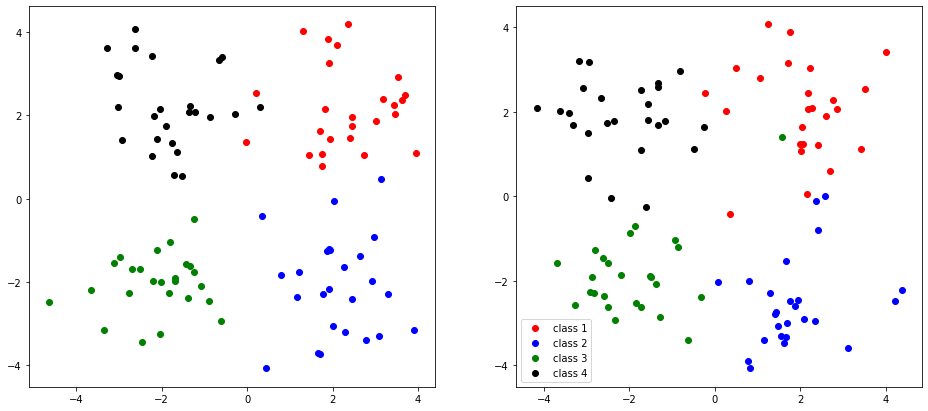

In [15]:
plot_2D(X_2D4cl_hs, Y_2D4cl_hs)

## 3 classes - 3 dimensions - medium separability

In [16]:
_, _, _, _, X_3D3cl_ms, _, _, _, _, Y_3D3cl_ms = np.load('data/lab4_2.p', allow_pickle=True)
x_train, x_test, y_train, y_test = normalize_data(X_3D3cl_ms, Y_3D3cl_ms)
train_test_evaluate(models)

,P( error ),P( correct | w_1 ),P( correct | w_2 ),P( correct | w_3 )
Maximum likelihood Reclassification,0.11,0.88,0.91,0.88
Maximum likelihood Testing,0.25,0.55,0.88,0.82
Parzen h1 = 0.1 Reclassification,0.00,1.00,1.00,1.00
Parzen h1 = 0.1 Testing,0.66,0.76,0.06,0.21
Parzen h1 = 5.0 Reclassification,0.08,0.91,0.94,0.91
Parzen h1 = 5.0 Testing,0.21,0.58,0.88,0.91
Nearest neighbours k = 1 Reclassification,0.00,1.00,1.00,1.00
Nearest neighbours k = 1 Testing,0.23,0.55,0.85,0.91
Nearest neighbours k = 5 Reclassification,0.16,0.85,0.88,0.79
Nearest neighbours k = 5 Testing,0.20,0.61,0.91,0.88


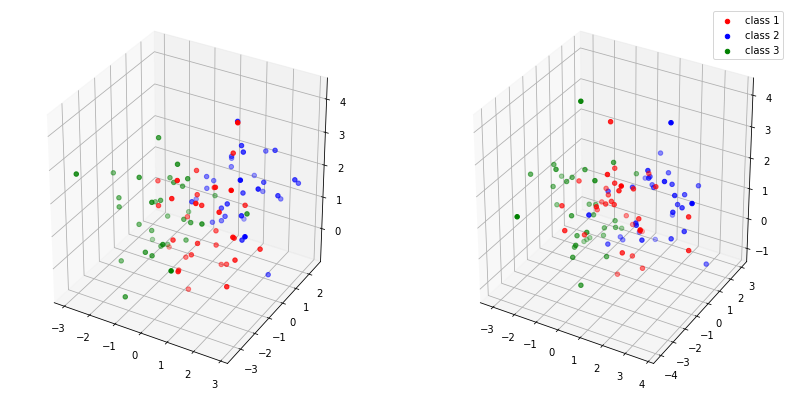

In [17]:
plot_3D(X_3D3cl_ms, Y_3D3cl_ms)